# Ising model using VQE

Import packages:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from qiskit import Aer, assemble
from qiskit.algorithms import VQE, VQD
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA # optimizers
from qiskit.circuit.library import EfficientSU2 # ansatz
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I, MatrixOp # operators

Defining new LaTeX commands for bra and ket vectors...
$\newcommand{\ket}[1]{\left| {#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1} \right|}$

## Transverse field Ising model (TFIM) - setup

Here we try to find the ground state energy of TFIM using VQE. The TIFM is given by the Hamiltonian: $$H = -J \sum_{<ij>} Z_i Z_j - h \sum_i X_i.$$
This would give us a degenerate ground state for $h = 0$ (all spins up or all spins down). To avoid this, we break degeneracy by introducing a small magnetic field in the z-direction, $h_z$, by adding to the Hamiltonian the term: $$-h_z \sum_i Z_i.$$ We require that $h_z \ll h$, by a few orders of magnitude.

### Ansatz and hamiltonian

First, we create an ansatz for our calculation from Ry, Rz and CNOT gates. The depth (number of layers) is set to 2 in order to reduce the number of parameters that need to be optimised by a classical optimiser. In this case, we have 12 free parameters.

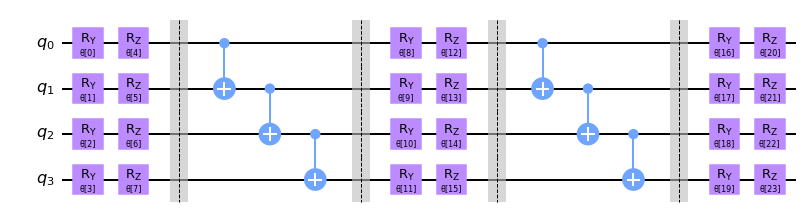

In [3]:
NUM_QUBITS = 4
ansatz = EfficientSU2(NUM_QUBITS, entanglement='linear',
                      insert_barriers=True, su2_gates=['ry', 'rz'], reps=2)
display(ansatz.decompose().draw('mpl'))

Then we choose the optimizer and the backend (here it is the Aer simulator). The number of shots is set to 1024. Then we create a quantum instance and a VQE object.

NOTES ON OPTIMIZERS:
- very low tolerance in COBYLA doesn't improve results, even can worsen them, setting a higher tolerance (0.001 to 0.0001) does not improve low-h magnetization, but can help with high-h results. Tolerance  of 0.01 is too large though. The minimum tolerance for after which there is no improvement is 0.00000001.
- Since speed is much improved for higher tolerance, it is probably sufficient to use 0.001.
- After lowering maxiter to 100, the results seem more chaotic. Similarly for 500. Looks good for 1000 and not improved beyond that.
- SLSQP actually runs fast when using kwarg for tolerance 'ftol'


SOLUTION? It seems like the solution is to set the initial point for the optimizer to be biased towards the -1 magnetization state! This is for example all zeroes, but it depends on the ansatz. But then, VQE solutions always fall into the same minimum and don't react to changes in the $h_z$.

According to vqe_advanced tutorial, using include_custom=True gives the most ideal results for a simulator.

In [4]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}
def callback(nfev, parameters, energy, stddev):
    intermediate_info["nfev"].append(nfev)
    intermediate_info["parameters"].append(parameters)
    intermediate_info["energy"].append(energy)
    intermediate_info["stddev"].append(stddev)

In [5]:
opt = SLSQP(maxiter=1000, tol=0.0000001)
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend=backend, shots=1024)
vqe = VQE(ansatz, optimizer=opt,
          quantum_instance=quantum_instance, include_custom=True, callback=callback)

Here we define the Ising Hamiltonian operator for n qubits. The $h$ and $J$ parameters correspond to the strength of transverse magnetic field and the coupling constant, respectively.

In [6]:
def ising_hamiltonian(n_qubits, h, h_z=0., J=1.):
    first_term_operators = np.full(n_qubits, I)
    second_term_operators = np.full(n_qubits, I)
    third_term_operators = np.full(n_qubits, I)
    
    first_term_operators[0] = X
    second_term_operators[0] = Z
    second_term_operators[1] = Z
    third_term_operators[0] = Z
    
    first_term = reduce(lambda x, y: x.tensor(y), first_term_operators)
    second_term = reduce(lambda x, y: x.tensor(y), second_term_operators)
    third_term = reduce(lambda x, y: x.tensor(y), third_term_operators)
    
    for i in range(n_qubits-1):
        first_term_operators = np.roll(first_term_operators, 1)
        first_term += reduce(lambda x, y: x.tensor(y), first_term_operators)
        
        second_term_operators = np.roll(second_term_operators, 1)
        second_term += reduce(lambda x, y: x.tensor(y), second_term_operators)
        
        third_term_operators = np.roll(third_term_operators, 1)
        third_term += reduce(lambda x, y: x.tensor(y), third_term_operators)
        
    hamiltonian = - h * first_term - J * second_term - h_z * third_term

    #Four-qubit case should look like this:
    #hamiltonian = - (h * ((X^I^I^I) + (I^X^I^I) + (I^I^X^I) + (I^I^I^X))
    #                + J * ((I^I^Z^Z) + (I^Z^Z^I) + (Z^Z^I^I) + (Z^I^I^Z))
    #                + h_z * ((Z^I^I^I) + (I^Z^I^I) + (I^I^Z^I) + (I^I^I^Z)))
    
    return hamiltonian

NOTES: the Ising Hamiltonian is a Hermitian matrix (good), but it is not unitary (bad?). Its determinant, depending on the fields, is in many cases equal to 0, so it is not invertible.

### Ground state energy and eigenvector functions

Find the exact diagonalisation using NumPy function that finds the eigenvalues and eigenvectors of a given matrix:

In [7]:
def find_exact_solution(hamiltonian_matrix):
    num_qubits = int(np.sqrt(hamiltonian_matrix.shape[0]))
    e_values, e_vectors = np.linalg.eigh(hamiltonian_matrix)
    e_values /= num_qubits
    return e_values, e_vectors

Compute and plot the spectrum of the Hamiltonian (for testing purposes):

In [8]:
h_values = np.arange(-0.1, 10.1, 0.1).tolist()
allevals = np.empty((NUM_QUBITS**2, len(h_values)))
import csv
with open('hamiltonian_spectrum.csv', 'w') as file:
    #writer = csv.writer(file)
    #writer.writerow(['% h', 'eig0', 'eig1', 'eig2', 'eig3', 'eig4', 'eig5', 'eig6', 'eig7', 'eig8', 'eig9', 'eig10', 'eig11', 'eig12', 'eig13', 'eig14', 'eig15'])
    for i, h in enumerate(h_values):
        hamilt = ising_hamiltonian(NUM_QUBITS, h)
        hamilt = hamilt.to_matrix()
        evals, evects = np.linalg.eigh(hamilt)
        evals /= NUM_QUBITS
        #print("------ h = {} ------".format(h))
        #print(evals)
        allevals[:, i] = evals
        row = evals.tolist()
        row.insert(0, h)
        #writer.writerow(row)

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_20304\2361610147.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 10.1)


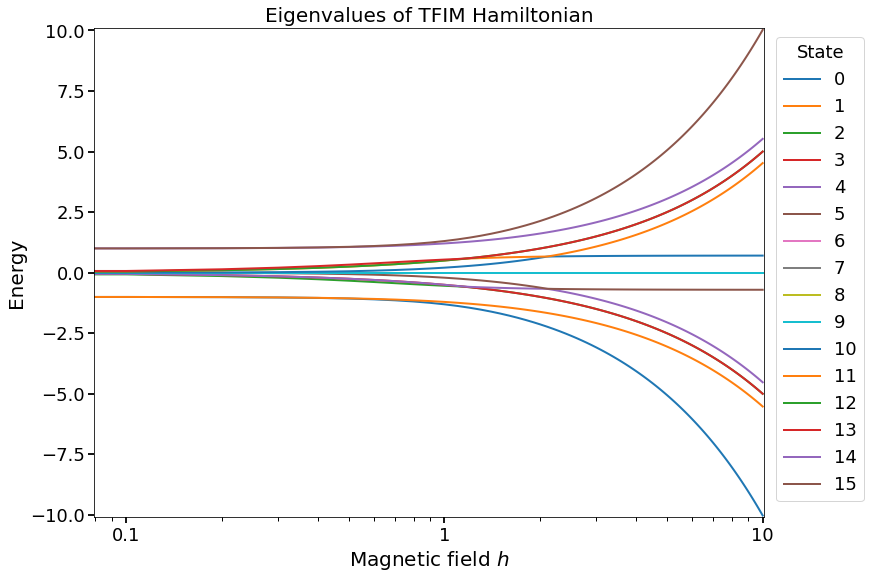

In [55]:
fig, ax = plt.subplots(figsize=(12, 9))
for i in range(NUM_QUBITS**2):
    ax.plot(h_values, allevals[i, :], label=str(i), linewidth=2)
ax.set_title('Eigenvalues of TFIM Hamiltonian', fontsize=20)
ax.set_xlabel(r'Magnetic field $h$', fontsize=20)
ax.set_xscale('log')
ax.set_xlim(0, 10.1)
ax.set_ylim(-10.1, 10.1)
ax.set_ylabel('Energy', fontsize=20)
ax.legend(bbox_to_anchor=(1.005, 1), fontsize=18, title='State', title_fontsize=18)
ax.tick_params(length=6, width=1.8, labelsize=18)
ax.tick_params(length=4, width=1, which='minor')
ax.set_xticks([0.1, 1, 10], labels=[0.1, 1, 10])
plt.show()
plt.close()

Notes on the spectrum:

For low fields, the ground and first excited states are basically degenerate, so very hard to distinguish by VQD.

For high fields, the gap between the ground and 1st excited state is large, so it is easy for VQD to differentiate between them. However, the first three excited states are all very close to each other and that is an issue for VQD, which can mix them or return in the wrong ordering.

Function to perform the VQE calculation for a given operator:

In [10]:
def find_VQE_solution(hamiltonian_operator, vqe_instance):
    num_qubits = hamiltonian_operator.num_qubits
    result = vqe_instance.compute_minimum_eigenvalue(hamiltonian_operator)
    energy = result.eigenvalue.real / num_qubits
    opt_params = result.optimal_parameters.values()
    return energy, opt_params

This part tries to simulate the ansatz circuit with the optimal parameters to find the final wavefunction. We use the statevector simulator to find the final state. This will give different results after each optimization (different optimal parametrs found), but the same results each time for the same parametrs of the circuit. The counts will not work, since they would change for every simulation of the circuit (even with the same parametres)!

In [11]:
def find_final_statevector(hamiltonian_operator, opt_params, vqe_instance):
    qc_list = vqe_instance.construct_circuit(opt_params, hamiltonian_operator)
    if len(qc_list) > 1:
        qc = qc_list[1]
    else:
        qc = qc_list[0]
    
    qc = qc.decompose()
    #qc.h([0, 1, 2, 3])
    qc.save_statevector()
    #display(qc.draw())
    
    qobj = assemble(qc)
    result = backend.run(qobj).result()
    final_state = np.asarray(result.get_statevector())

    return final_state

The function below plots the probabilities of different basis states obtained from both VQE and exact diagonalisation, to let us compare them visually:

In [12]:
def plot_state_probabilities(exact_state, vqe_state, h_field):
    # Generate strings representing the computational basis states
    basis_states = [str(bin(x)[2:]) for x in range(2**NUM_QUBITS)]
    basis_states = [x.rjust(4, '0') for x in basis_states]
    
    # Create a figure and plot probabilities
    fig, ax = plt.subplots(figsize=(6, 3))
    x_values = np.arange(2 ** NUM_QUBITS)
    ax.scatter(x_values, abs(exact_state)**2, label="Exact", s=35)
    ax.scatter(x_values, abs(vqe_state)**2, label="VQE", s=35)
    ax.set_ylim(-0.05, 1.05)
    
    # Add some information to the plot
    ax.set_title("h = {0:.3f}".format(h_field), fontsize=14)
    ax.set_xlabel("Computational basis state", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    ax.set_xticks(x_values)
    ax.set_xticklabels(basis_states, rotation=50, fontsize=12)
    ax.legend(fontsize=12, loc='best')
    
    return fig

### Fidelity and magentisation functions

This function computes the fidelity between VQE final state and the exact eigenstate:

In [13]:
def fidelity(exact_state, vqe_state):
    fidelity = np.abs(np.dot(exact_state, vqe_state))**2
    return fidelity

This function creates a list of fidelities given lists of exact and VQE states:

In [14]:
def compute_fidelities(exact_eigvect_list, vqe_eigvect_list):
    fidelity_list = []
    for (exact_state, vqe_state) in zip(exact_eigvect_list, vqe_eigvect_list):
        fid = fidelity(exact_state, vqe_state)
        fidelity_list.append(fid)
    return fidelity_list

Here we define the magnetisation operators:

In [21]:
def magnetisation_operator(n_qubits, axis):
    terms = np.full(n_qubits, I)
    if axis == 'x':
        terms[0] = X
    elif axis =='z':
        terms[0] = Z
    else:
        print("Invalid argument. Axis must be 'x' or 'y'!")
        return None
    
    operator = reduce(lambda x, y: x.tensor(y), terms)
    
    for i in range(n_qubits-1):
        terms = np.roll(terms, 1)
        operator += reduce(lambda x, y: x.tensor(y), terms)
    
    return operator

x_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'x')
z_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'z')

Now we compute the magnetisation for the exact case. Note that we return the value normalised by the number of qubits.

In [16]:
def exact_magnetisation(magnetisation_operator, eigenvector):
    matrix = magnetisation_operator.to_matrix()
    product = matrix.dot(eigenvector)
    magnetisation = np.vdot(eigenvector, product).real
    return magnetisation / NUM_QUBITS

This is a function that prints all the important results in a nice form:

In [17]:
def print_all_results(results):
    np.set_printoptions(precision=3, linewidth=120)
    
    for (h, energy, eigvect, mag, vqe_energy, vqe_eigvect, vqe_mag, fidelity) in results:
        print("\n==================== h = {0:.3f} ====================".format(h))
        
        print("Ground state ENERGY per qubit:\n\tExact: {0:.8f}\n\tVQE:   {1:.8f}".format(energy, vqe_energy))
        print("MAGNETISATION per qubit:\n\tExact: {0:.3f}\n\tVQE:   {1:.3f}".format(mag, vqe_mag))
        print("FIDELITY: {0:.3f}".format(fidelity))
        
        print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE:   {1}".format(eigvect.real, vqe_eigvect.real))
        fig = plot_state_probabilities(eigvect, vqe_eigvect, h)
        display(fig)
        plt.close()

    return

## TFIM simulation for various field strengths

Let's define a function that does the full VQE computation for a given field strength $h$:

In [18]:
def vqe_ising_model(vqe_instance, h_field, h_z=0.001, J=1.):
    hamiltonian_operator = ising_hamiltonian(NUM_QUBITS, h_field, h_z=h_z, J=J)
    
    energy, opt_params = find_VQE_solution(hamiltonian_operator, vqe_instance)
    final_state = find_final_statevector(hamiltonian_operator, opt_params, vqe_instance)
    
    magnetisation_z = vqe_instance.get_energy_evaluation(z_magnetisation_op)(list(opt_params)) / NUM_QUBITS
    magnetisation_x = vqe_instance.get_energy_evaluation(x_magnetisation_op)(list(opt_params)) / NUM_QUBITS
    
    return energy, final_state, magnetisation_z, magnetisation_x

Define a list of values of magnetic field that we want to investigate and the value of $h_z$ to break degeneracy for small $h$. However, changing $h_z$ also seems to change the position of the phase transition... but only for the exact solution! VQE calculation doesn't seem to be affected.

In [22]:
h_list = (10 ** np.linspace(-1.5, 1.5, 100)).tolist()
#h_list.append(1.5)
#h_list.append(1.25)
#h_list.append(0.75)
#h_list.append(2.0)
#h_list.sort()

NUM_QUBITS = 12
h_bias = 0.00001

### Exact solution

Here we perform the exact calculation for these field values and then plot the energy and magnetisations:

In [ ]:
exact_magnetisation_z_list = []
exact_magnetisation_x_list = []
exact_energy_list = []
exact_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    hamiltonian = ising_hamiltonian(NUM_QUBITS, h, h_z=h_bias)
    exact_energies, exact_eigenvectors = find_exact_solution(hamiltonian.to_matrix())
    exact_eigenvector_list.append(exact_eigenvectors[:, 0])
    exact_energy_list.append(exact_energies[0])
    exact_magnetisation_z_list.append(exact_magnetisation(z_magnetisation_op, exact_eigenvectors[:, 0]))
    exact_magnetisation_x_list.append(exact_magnetisation(x_magnetisation_op, exact_eigenvectors[:, 0]))
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.034
Computing for h = 0.036
Computing for h = 0.039
Computing for h = 0.042
Computing for h = 0.045
Computing for h = 0.048
Computing for h = 0.052
Computing for h = 0.055
Computing for h = 0.059
Computing for h = 0.064
Computing for h = 0.068
Computing for h = 0.073
Computing for h = 0.078
Computing for h = 0.084
Computing for h = 0.090
Computing for h = 0.097
Computing for h = 0.104
Computing for h = 0.111
Computing for h = 0.119
Computing for h = 0.128
Computing for h = 0.137
Computing for h = 0.147
Computing for h = 0.157
Computing for h = 0.169
Computing for h = 0.181
Computing for h = 0.194
Computing for h = 0.208
Computing for h = 0.223
Computing for h = 0.239
Computing for h = 0.257
Computing for h = 0.275
Computing for h = 0.295
Computing for h = 0.316
Computing for h = 0.339
Computing for h = 0.364
Computing for h = 0.390
Computing for h = 0.418
Computing for h = 0.448
Computing for h = 0.481
Computing for h = 0.515
Computing for h 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(h_list, exact_energy_list, c='g', linewidth=3)
axes[0].set_title("Energy", fontsize=16)
axes[0].set_xscale('log')
axes[0].tick_params(which='minor', length=3, width=1)
axes[0].tick_params(length=6, width=1.5, labelsize=14)
axes[0].set_xlabel(r'$h$', fontsize=16, loc='right', labelpad=-15)
axes[1].plot(h_list, exact_magnetisation_z_list, c='b', linewidth=3)
axes[1].set_title(r"Magnetisation in $z$", fontsize=16)
axes[1].set_xscale('log')
axes[1].tick_params(length=6, width=1.5, labelsize=14)
axes[1].tick_params(which='minor', length=3, width=1)
axes[1].set_xlabel(r'$h$', fontsize=16, loc='right', labelpad=-15)
axes[2].plot(h_list, exact_magnetisation_x_list, c='b', linewidth=3)
axes[2].set_title(r"Magnetisation in $x$", fontsize=16)
axes[2].set_xscale('log')
axes[2].set_xlabel(r'$h$', fontsize=16, loc='right', labelpad=-15)
axes[2].tick_params(which='minor', length=3, width=1)
axes[2].tick_params(length=6, width=1.5, labelsize=14)

### VQE solution

Here is the loop that performs the VQE calculation for the different values of $h$:

In [64]:
vqe_magnetisation_z_list = []
vqe_magnetisation_x_list = []
vqe_energy_list = []
vqe_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}
    vqe_results = vqe_ising_model(vqe, h, h_z=h_bias)
    vqe_energy_list.append(vqe_results[0])
    vqe_eigenvector_list.append(vqe_results[1])
    vqe_magnetisation_z_list.append(vqe_results[2])
    vqe_magnetisation_x_list.append(vqe_results[3])
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000


KeyboardInterrupt: 

Here we compute fidelities and print all the results nicely:

In [ ]:
fidelity_list = compute_fidelities(exact_eigenvector_list, vqe_eigenvector_list)
results_list = zip(h_list, exact_energy_list, exact_eigenvector_list, exact_magnetisation_z_list,
                   vqe_energy_list, vqe_eigenvector_list, vqe_magnetisation_z_list, fidelity_list)
print_all_results(results_list)

Finally, we plot the data obtained from VQE, together with the exact values. Fidelity plots are repeated below each of the other plots to help identify less reliable data points.

In [ ]:
# Energy plot
fig_energy, ax_energy = plt.subplots(figsize=(6, 4))

ax_energy.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_energy.scatter(h_list, vqe_energy_list, s=40, c='g', label='VQE')
ax_energy.plot(h_list, exact_energy_list, c='g', alpha=0.7, label='Exact')
ax_energy.set_title("Ground state energy vs $h$", fontsize=16)
ax_energy.set_xscale('log')
ax_energy.grid(True)
ax_energy.set_xticks([0.1, 1, 10])
ax_energy.set_xticklabels([0.1, 1, 10])
ax_energy.legend(loc='best', fontsize=12);

# Energy error plot
fig_energy_diff, ax_energy_diff = plt.subplots(figsize=(6, 4))

energy_error_list = 100 * np.abs((np.array(vqe_energy_list) - np.array(exact_energy_list)) / np.array(exact_energy_list))
ax_energy_diff.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_energy_diff.scatter(h_list, energy_error_list, s=40, c='g', label='VQE')
ax_energy_diff.set_title("Energy error in % vs $h$", fontsize=16)
ax_energy_diff.set_xscale('log')
ax_energy_diff.grid(True)
ax_energy_diff.set_xticks([0.1, 1, 10])
ax_energy_diff.set_xticklabels([0.1, 1, 10]);

# Magnetisation in z plot
fig_magz, ax_magz = plt.subplots(figsize=(6, 4))

ax_magz.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_magz.scatter(h_list, vqe_magnetisation_z_list, s=40, c='b', label='VQE')
ax_magz.plot(h_list, exact_magnetisation_z_list, c='b', alpha=0.7, label='Exact')
ax_magz.set_title("Magnetisation in $z$-direction vs $h$", fontsize=16)
ax_magz.set_xscale('log')
ax_magz.grid(True)
ax_magz.set_xticks([0.1, 1, 10])
ax_magz.set_xticklabels([0.1, 1, 10])
ax_magz.legend(loc='best', fontsize=12);


# Magnetisation in x plot
fig_magx, ax_magx = plt.subplots(figsize=(6, 4))

ax_magx.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_magx.scatter(h_list, vqe_magnetisation_x_list, s=40, c='b', label='VQE')
ax_magx.plot(h_list, exact_magnetisation_x_list, c='b', alpha=0.7, label='Exact')
ax_magx.set_title("Magnetisation in $x$-direction vs $h$", fontsize=16)
ax_magx.set_xscale('log')
ax_magx.grid(True)
ax_magx.set_xticks([0.1, 1, 10])
ax_magx.set_xticklabels([0.1, 1, 10])
ax_magx.legend(loc='best', fontsize=12);

# Fidelity plot
fig_fidel, ax_fidel = plt.subplots(figsize=(6, 4))

ax_fidel.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_fidel.scatter(h_list, fidelity_list, s=40, c='k')
ax_fidel.set_title("State fidelity vs $h$", fontsize=16)
ax_fidel.set_xscale('log')
ax_fidel.grid(True)
ax_fidel.set_xticks([0.1, 1, 10])
ax_fidel.set_xticklabels([0.1, 1, 10]);

In [ ]:
#fig_energy.savefig("energy_3.png")
#fig_energy_diff.savefig("energy_diff_3.png")
#fig_magz.savefig("mag_z_3.png")
#fig_magx.savefig("mag_x_3.png")
#fig_fidel.savefig("fidelity_3.png")

Using the SLSQP optimizer with very small ftol and maxiter=1000, we can lower the bias to about 0.25, but only sometimes. This is also possible thanks to including Rz gates in the ansatz. COBYLA has problems with more parameters (using Rz gates).

## Excited states - VQD

### Setup and exact solution

The Variational Quantum Deflation algorithm allows us to find excited states after we have found the ground state. It is simple to implement - we just need to modify our Hamiltonian by adding a penalty term and repeat the VQE calculation. The new hamiltonian is $$H_1 = H + \beta \ket{\psi(\theta_0^*)} \bra{\psi(\theta_0^*)},$$ where $\psi(\theta_0^*)$ is the approximate ground state wavefunction, found previously using VQE and $H$ is the original Hamiltonian.

First, we choose $h = 1$, since for very low $h$, the gap is very small. We do not use any bias, so that $h_z = 0$. Actually, if we use $h_z = 0.001$, then we still get precision of at least 3 decimal places on the exact result, so we should be safe to apply a small bias, but not much more (certainly not 0.1). If we use a high value for transverse magnetic field $h$, then the applied bias magnetic field doesn't mattter anyway, so can be set equivalently to 0. Then, we define the Hamiltonian $H$.

In [25]:
h_field = 10.0
h_bias = 0.001
hamiltonian_0 = ising_hamiltonian(NUM_QUBITS, h_field, h_z=h_bias)

We start by finding the exact eigenvalues and eigenvectors. We need them for comparison and to estimate the gap between the ground and first excited states.

In [26]:
exact_energies, exact_eigenvectors = find_exact_solution(hamiltonian_0.to_matrix())
exact_magnetisation_z_0 = exact_magnetisation(z_magnetisation_op, exact_eigenvectors[:, 0])
exact_magnetisation_x_0 = exact_magnetisation(x_magnetisation_op, exact_eigenvectors[:, 0])
exact_magnetisation_z_1 = exact_magnetisation(z_magnetisation_op, exact_eigenvectors[:, 1])
exact_magnetisation_x_1 = exact_magnetisation(x_magnetisation_op, exact_eigenvectors[:, 1])
exact_magnetisation_z_2 = exact_magnetisation(z_magnetisation_op, exact_eigenvectors[:, 2])
exact_magnetisation_x_2 = exact_magnetisation(x_magnetisation_op, exact_eigenvectors[:, 2])

In [27]:
print("Ground state energy:      {0:.8f}".format(exact_energies[0] * NUM_QUBITS))
print("1st excited state energy: {0:.8f}".format(exact_energies[1] * NUM_QUBITS))
gap_per_qubit = exact_energies[1] - exact_energies[0]
print("Energy gap between these states: {0:.8f}".format(gap_per_qubit * NUM_QUBITS))

Ground state energy:      -40.10037430
1st excited state energy: -22.09975131
Energy gap between these states: 18.00062298


### My own implementation

First, we define the optimizer and the VQE instance:

**Important observations**

- SLSQP optimizer is terrible for VQD, for unknown reasons it gets stuck at some random points, returns energy way off the exact one and a messy eigenvector.
- COBYLA is much better, but you need to set very, very low tolerance to get close to the real state (without bias field) and even then it is not guaranteed.
- SPSA does actually a great job too, but (almost?) always falls into fully $\ket{1111}$ or $\ket{0000}$ state instead of a 50/50 as for exact solution without bias.

I have also noticed that with high bias of 0.1, setting lower tolerance in COBYLA (1e-12) is more likely to give the correct +/- magnetisation state. There is also a small improvement in fidelity with the number of iterations, even though energy doesn't change much.

Ansatz for VQD requires larger depth than VQE (about twice as much), so we change reps to 4.

In [28]:
opt = COBYLA(maxiter=5000, tol=1e-15)
vqe = VQE(ansatz, optimizer=opt, quantum_instance=quantum_instance,
          include_custom=True, callback=callback)
ansatz = EfficientSU2(NUM_QUBITS, entanglement='linear',
                      insert_barriers=True, su2_gates=['ry'], reps=4)

#### Ground state

Then, we calculate the ground state using VQE:

In [29]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}

energy_0, opt_params_0 = find_VQE_solution(hamiltonian_0, vqe)
eigenvector_0 = find_final_statevector(hamiltonian_0, opt_params_0, vqe)
magnetisation_z_0 = vqe.get_energy_evaluation(z_magnetisation_op)(list(opt_params_0)) / NUM_QUBITS
magnetisation_x_0 = vqe.get_energy_evaluation(x_magnetisation_op)(list(opt_params_0)) / NUM_QUBITS
fidelity_0 = fidelity(exact_eigenvectors[:, 0], eigenvector_0)


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.02509357
	VQE:   -10.01409955
MAGNETISATION in z per qubit:
	Exact: 0.000
	VQE:   -0.000
MAGNETISATION in x per qubit:
	Exact: 0.997
	VQE:   0.999
FIDELITY: 0.999

Ground state EIGENVECTOR:
	Exact: [ 0.276  0.249  0.249  0.249  0.249  0.226  0.249  0.249  0.249  0.249  0.226  0.249  0.249  0.249  0.249  0.276]
	VQE:   [ 0.262  0.250  0.247  0.260  0.248  0.235  0.239  0.248  0.250  0.237  0.236  0.247  0.260  0.249  0.248  0.264]


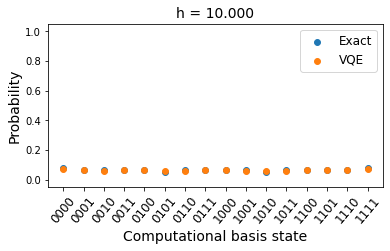

In [30]:
print("\n==================== h = {0:.3f} ====================".format(h_field))

print("Ground state ENERGY per qubit:\n\tExact: {0:.8f}\n\tVQE:   {1:.8f}".format(exact_energies[0], energy_0))
print("MAGNETISATION in z per qubit:\n\tExact: {0:.3f}\n\tVQE:   {1:.3f}".format(exact_magnetisation_z_0, magnetisation_z_0))
print("MAGNETISATION in x per qubit:\n\tExact: {0:.3f}\n\tVQE:   {1:.3f}".format(exact_magnetisation_x_0, magnetisation_x_0))
print("FIDELITY: {0:.3f}".format(fidelity_0))

np.set_printoptions(precision=3, linewidth=120, sign=' ', floatmode='fixed')
print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE:   {1}".format(exact_eigenvectors[:, 0].real, eigenvector_0.real))

fig = plot_state_probabilities(exact_eigenvectors[:, 0], eigenvector_0, h_field)
display(fig)
plt.close()

Here is the convergence plot. Useful for estimating the quality of optimizers.

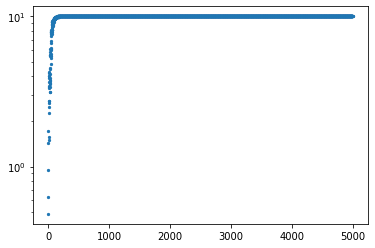

In [31]:
plt.scatter(intermediate_info['nfev'][:-2], np.abs(np.array(intermediate_info['energy'][:-2])) / NUM_QUBITS, s=5)
plt.yscale('log')

#### 1st excited state

Now, we can compute the excited state. First, we define $\beta$, such that it is larger than the energy gap. Then we define the new Hamiltonian $H_1$, using the ground state eigenvector as found above from VQE.

In [32]:
beta = 60
hamiltonian_1 = MatrixOp(hamiltonian_0.to_matrix()) + MatrixOp(beta * np.outer(eigenvector_0, eigenvector_0))

In [33]:
intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}

energy_1, opt_params_1 = find_VQE_solution(hamiltonian_1, vqe)
eigenvector_1 = find_final_statevector(hamiltonian_1, opt_params_1, vqe)
magnetisation_z_1 = vqe.get_energy_evaluation(z_magnetisation_op)(list(opt_params_1)) / NUM_QUBITS
magnetisation_x_1 = vqe.get_energy_evaluation(x_magnetisation_op)(list(opt_params_1)) / NUM_QUBITS
fidelity_1 = fidelity(exact_eigenvectors[:, 1], eigenvector_1)


==================== h = 10.000 ====================
1st excited state ENERGY per qubit:
	Exact: -5.52493783
	VQE:   0.09225723
MAGNETISATION in z per qubit:
	Exact: 0.000
	VQE:   -0.307
MAGNETISATION in x per qubit:
	Exact: 0.498
	VQE:   -0.110
FIDELITY: 0.042

1st excited state EIGENVECTOR:
	Exact: [ 5.243e-01  2.372e-01  2.372e-01 -5.737e-05  2.372e-01 -4.858e-05 -5.737e-05 -2.373e-01  2.372e-01 -5.737e-05
 -4.858e-05 -2.373e-01 -5.737e-05 -2.373e-01 -2.373e-01 -5.242e-01]
	VQE:   [ 0.015 -0.042 -0.010 -0.097  0.059  0.020  0.391 -0.650  0.019  0.028 -0.012  0.067  0.048  0.070 -0.145 -0.066]


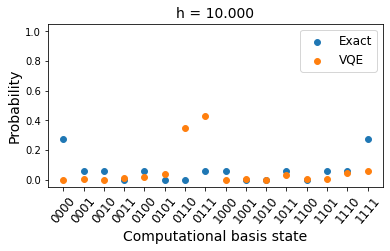

In [34]:
print("\n==================== h = {0:.3f} ====================".format(h_field))

print("1st excited state ENERGY per qubit:\n\tExact: {0:.8f}\n\tVQE:   {1:.8f}".format(exact_energies[1], energy_1))
print("MAGNETISATION in z per qubit:\n\tExact: {0:.3f}\n\tVQE:   {1:.3f}".format(exact_magnetisation_z_1, magnetisation_z_1))
print("MAGNETISATION in x per qubit:\n\tExact: {0:.3f}\n\tVQE:   {1:.3f}".format(exact_magnetisation_x_1, magnetisation_x_1))
print("FIDELITY: {0:.3f}".format(fidelity_1))

np.set_printoptions(precision=3, linewidth=120, sign=' ', floatmode='fixed')
print("\n1st excited state EIGENVECTOR:\n\tExact: {0}\n\tVQE:   {1}".format(exact_eigenvectors[:, 1].real, eigenvector_1.real))

fig = plot_state_probabilities(exact_eigenvectors[:, 1], eigenvector_1, h_field)
display(fig)
plt.close()

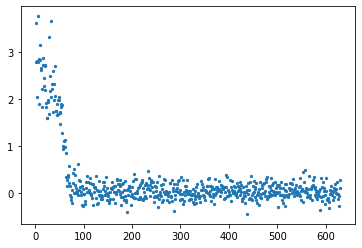

In [35]:
plt.scatter(intermediate_info['nfev'][:-2], np.array(intermediate_info['energy'][:-2]) / NUM_QUBITS, s=5)

**THINGS TO CONSIDER:**
- Bias or no bias?
- Optimizer choice
- Improving ground state eigenvector
- Choice of $\beta$ parameter
- Ansatz


I have checked that increasing the ansatz depth to 4 (from 2 for simple VQE) does help in finding the correct energy. The x-magnetisation also looks good now, but z-magnetisation does not, which is due to very low state fidelity - or maybe I was just lucky one time.

### Qiskit's implementation

This is the built-in Qiskit's implementation of the VQD algorithm:

In [36]:
beta = 50
opt = COBYLA(maxiter=5000, tol=1e-12)
vqd = VQD(ansatz=ansatz, k=3, betas=[beta, beta], include_custom=True, quantum_instance=quantum_instance, optimizer=opt)

In [37]:
result = vqd.compute_eigenvalues(hamiltonian_0, aux_operators=[z_magnetisation_op, x_magnetisation_op])

First, the results for the ground state:

In [38]:
energy_0 = result.eigenvalues[0].real / NUM_QUBITS
eigenvector_0 = result.eigenstates[0].to_matrix()
magnetisation_z_0 = result.aux_operator_eigenvalues[0][0][0] / NUM_QUBITS
magnetisation_x_0 = result.aux_operator_eigenvalues[0][1][0] / NUM_QUBITS
fidelity_0 = fidelity(exact_eigenvectors[:, 0], eigenvector_0)


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.025
	VQE: -10.021
MAGNETISATION in z per qubit:
	Exact: 0.000
	VQE: 0.000
MAGNETISATION in x per qubit:
	Exact: 0.997
	VQE: 0.998
FIDELITY: 0.993

Ground state EIGENVECTOR:
	Exact: [ 0.276  0.249  0.249  0.249  0.249  0.226  0.249  0.249  0.249  0.249  0.226  0.249  0.249  0.249  0.249  0.276]
	VQE: [ 0.269  0.272  0.246  0.200  0.219  0.228  0.272  0.244  0.242  0.276  0.225  0.250  0.267  0.242  0.280  0.252]


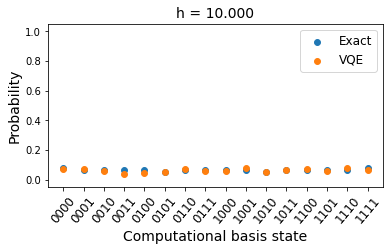

In [39]:
print("\n==================== h = {0:.3f} ====================".format(h_field))

print("Ground state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_energies[0], energy_0))
print("MAGNETISATION in z per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_z_0, magnetisation_z_0))
print("MAGNETISATION in x per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_x_0, magnetisation_x_0))
print("FIDELITY: {0:.3f}".format(fidelity_0))

np.set_printoptions(precision=3, linewidth=120)
print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(exact_eigenvectors[:, 0].real, eigenvector_0.real))

fig = plot_state_probabilities(exact_eigenvectors[:, 0], eigenvector_0, h_field)
display(fig)
plt.close()

And next, the 1st excited state:

In [40]:
energy_1 = result.eigenvalues[1].real / NUM_QUBITS
eigenvector_1 = result.eigenstates[1].to_matrix()
magnetisation_z_1 = result.aux_operator_eigenvalues[1][0][0] / NUM_QUBITS
magnetisation_x_1 = result.aux_operator_eigenvalues[1][1][0] / NUM_QUBITS
fidelity_1 = fidelity(exact_eigenvectors[:, 1], eigenvector_1)


==================== h = 10.000 ====================
1st excited state ENERGY per qubit:
	Exact: -5.525
	VQE: -4.926
MAGNETISATION in z per qubit:
	Exact: 0.000
	VQE: -0.010
MAGNETISATION in x per qubit:
	Exact: 0.498
	VQE: 0.497
FIDELITY: 0.001

1st excited state EIGENVECTOR:
	Exact: [ 5.243e-01  2.372e-01  2.372e-01 -5.737e-05  2.372e-01 -4.858e-05 -5.737e-05 -2.373e-01  2.372e-01 -5.737e-05
 -4.858e-05 -2.373e-01 -5.737e-05 -2.373e-01 -2.373e-01 -5.242e-01]
	VQE: [ 0.000  0.000  0.214  0.117  0.288  0.125  0.471  0.320  0.338  0.468  0.153  0.286  0.133  0.240  0.000  0.062]


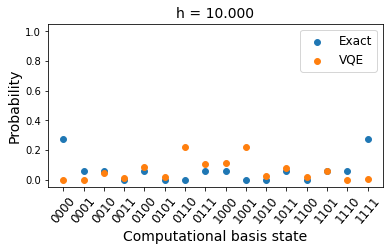

In [41]:
print("\n==================== h = {0:.3f} ====================".format(h_field))

print("1st excited state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_energies[1], energy_1))
print("MAGNETISATION in z per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_z_1, magnetisation_z_1))
print("MAGNETISATION in x per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_x_1, magnetisation_x_1))
print("FIDELITY: {0:.3f}".format(fidelity_1))

np.set_printoptions(precision=3, linewidth=120)
print("\n1st excited state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(exact_eigenvectors[:, 1].real, eigenvector_1.real))

fig = plot_state_probabilities(exact_eigenvectors[:, 1], eigenvector_1, h_field)
display(fig)
plt.close()

In [42]:
energy_2 = result.eigenvalues[2].real / NUM_QUBITS
eigenvector_2 = result.eigenstates[2].to_matrix()
magnetisation_z_2 = result.aux_operator_eigenvalues[2][0][0] / NUM_QUBITS
magnetisation_x_2 = result.aux_operator_eigenvalues[2][1][0] / NUM_QUBITS
fidelity_2 = fidelity(exact_eigenvectors[:, 2], eigenvector_2)


==================== h = 10.000 ====================
2nd excited state ENERGY per qubit:
	Exact: -5.525
	VQE: -4.897
MAGNETISATION in z per qubit:
	Exact: 0.000
	VQE: -0.002
MAGNETISATION in x per qubit:
	Exact: 0.498
	VQE: 0.496
FIDELITY: 0.000

1st excited state EIGENVECTOR:
	Exact: [ 5.243e-01  2.372e-01  2.372e-01 -5.737e-05  2.372e-01 -4.858e-05 -5.737e-05 -2.373e-01  2.372e-01 -5.737e-05
 -4.858e-05 -2.373e-01 -5.737e-05 -2.373e-01 -2.373e-01 -5.242e-01]
	VQE: [ 0.000  0.417  0.044  0.428  0.210  0.223  0.205  0.185  0.190  0.203  0.113  0.162  0.406  0.000  0.432  0.054]


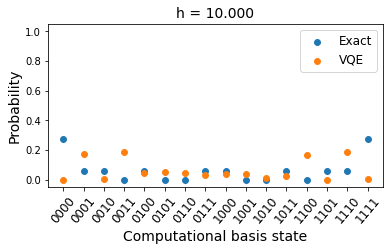

In [43]:
print("\n==================== h = {0:.3f} ====================".format(h_field))

print("2nd excited state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_energies[1], energy_2))
print("MAGNETISATION in z per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_z_2, magnetisation_z_2))
print("MAGNETISATION in x per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_x_2, magnetisation_x_2))
print("FIDELITY: {0:.3f}".format(fidelity_1))

np.set_printoptions(precision=3, linewidth=120)
print("\n1st excited state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(exact_eigenvectors[:, 2].real, eigenvector_2.real))

fig = plot_state_probabilities(exact_eigenvectors[:, 2], eigenvector_2, h_field)
display(fig)
plt.close()